# Lab 8: Filtering in the time- and frequency domains 

25 March 2021

Let's take a look at spectrograms (see https://en.wikipedia.org/wiki/Spectrogram) using some synthetic data.

Synthetic data are generated in a similar fashion as in the lecture demo, but with different frequencies. 

In [1]:
%matplotlib notebook

import numpy as np 
import scipy.fft as fft
from scipy import signal
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True

In [2]:
N      = 1001                                  # number of points in vector
tmin   = 0.                                    # t_0: inital time 
tmax   = 100.                                  # t_N: final time 
t, dt  = np.linspace(tmin,tmax,N,retstep=True) # create the time vector 
f_samp = 1/dt                                  # sampling frequency

# Create synthetic data
y2   = np.sin(2*np.pi*t/5.)      # create synthetic sinusoid
y3   = np.sin(2*np.pi*t/2.)      # create synthetic sinusoid
y4   = np.sin(2*np.pi*t/1.25)    # create synthetic sinusoid
y5   = y2 + y3 + y4              # sum sinusoids to create waveform
ys   = [y2,y3,y4,y5]             # make a list of the y-data to be indexed

# Compute power spectra
f2, pxx2 = signal.periodogram(y2,fs=f_samp,nfft=N, scaling='spectrum')
f3, pxx3 = signal.periodogram(y3,fs=f_samp,nfft=N, scaling='spectrum')
f4, pxx4 = signal.periodogram(y4,fs=f_samp,nfft=N, scaling='spectrum')
f5, pxx5 = signal.periodogram(y5,fs=f_samp,nfft=N, scaling='spectrum')
fs       = [f2,f3,f4,f5]
pxxsc    = [pxx2,pxx3,pxx4,pxx5]

<IPython.core.display.Javascript object>


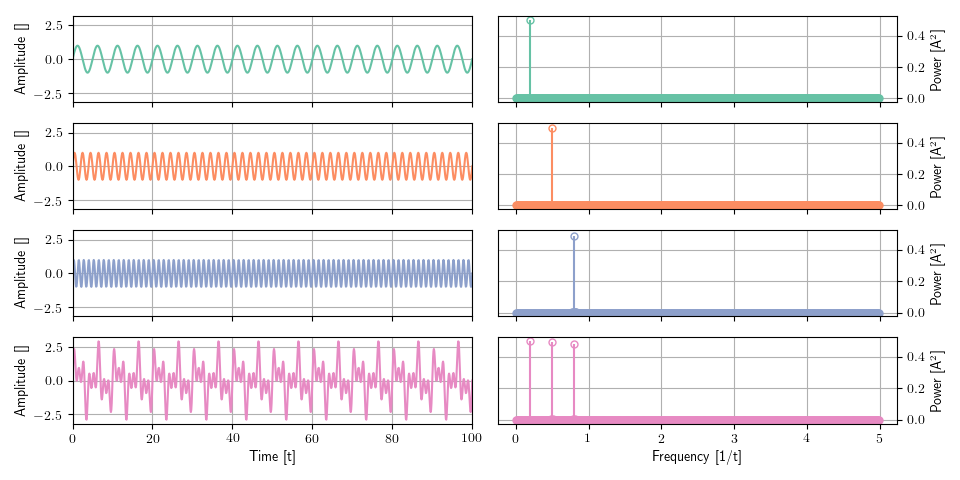

In [5]:
# Plot original timeseries and power spectra

fig, ax = plt.subplots(4,2,sharex='col',sharey='col',figsize=(9.6,4.8))
color = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']
for i in range(0,4): 
    ax[i,0].plot(t, ys[i],c=color[i])
    ax[i,0].set_xlim(tmin,tmax)
    ax[i,0].set_ylabel('Amplitude []')
    ax[i,0].grid(True)

    (markers, stemlines, baseline) = ax[i,1].stem(fs[i], pxxsc[i],basefmt='None',use_line_collection=True)
    plt.setp(markers, marker='o', markersize=5.0, markerfacecolor='None',markeredgecolor=color[i])
    plt.setp(stemlines, color=color[i])

    #ax[i,1].set_xlim(0,1)
    #ax[i,1].set_ylim(None,60)
    ax[i,1].yaxis.tick_right()
    ax[i,1].yaxis.set_label_position("right")
    ax[i,1].set_ylabel('Power [A$^2$]')
    ax[i,1].grid(True)

ax[-1,0].set_xlabel('Time [t]')
ax[-1,1].set_xlabel('Frequency [1/t]')
plt.tight_layout();

<IPython.core.display.Javascript object>


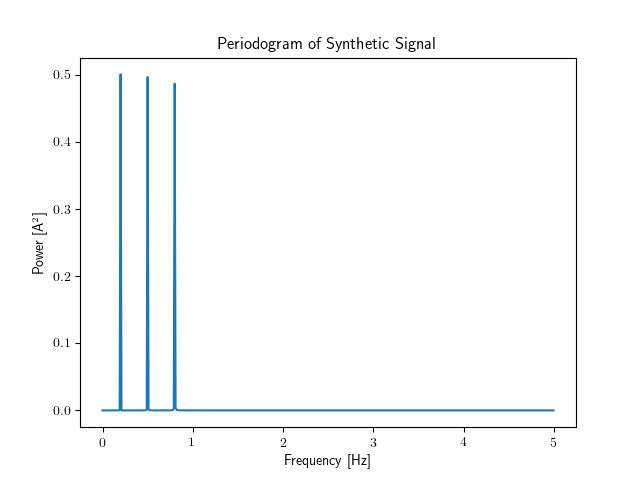

Text(0.5, 0, 'Frequency [Hz]')

In [6]:
# Plot periodogram with 'plot' rather than 'stem'
fig, ax = plt.subplots()

ax.plot(f5, pxx5)

ax.set_title('Periodogram of Synthetic Signal')
ax.set_ylabel('Power [A$^2$]')
ax.set_xlabel('Frequency [Hz]')


<IPython.core.display.Javascript object>


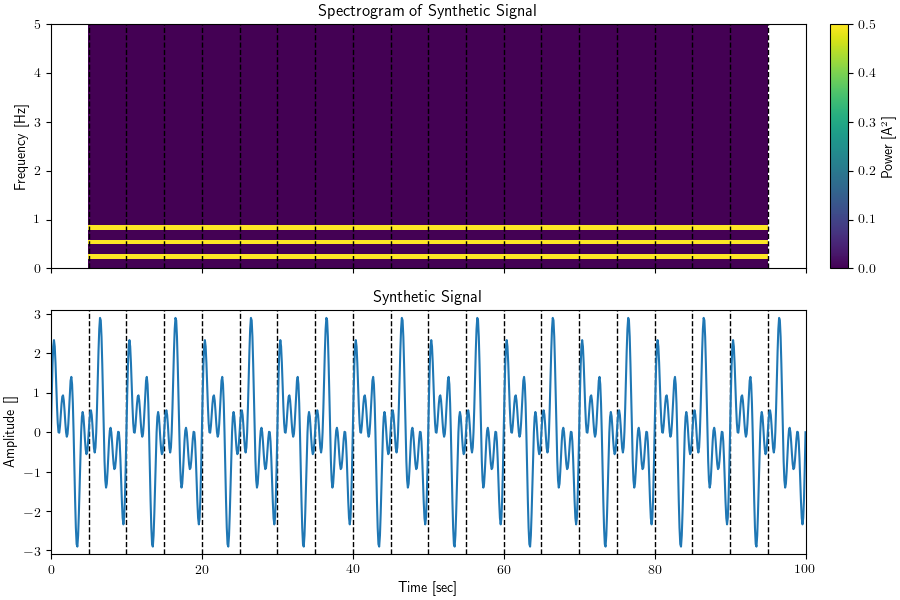

In [8]:
# Let's compute the spectrogram with some fine-tuned key word arguments to 
# see what's really happening underneath the hood of 'spectrogram'. 
f, t_s, Sxx = signal.spectrogram(y5, fs=1/dt, 
                                 window="boxcar", 
                                 scaling='spectrum', 
                                 nperseg  = 100,
                                 noverlap = 50, 
                                 nfft     = 100
                              )


# Create a two-panel figure
fig, ax = plt.subplots(2,1,sharex=True, figsize=(9,6), constrained_layout=True)

# Plot the power (Sxx) as a function of time (t_s) and frequency (f)
im = ax[0].pcolormesh(t_s, f, Sxx, shading='nearest')
# Plot the edges of the time windows used to calculate spectrogram
ax[0].vlines(t_s, ymin=0.0, ymax=5.0, color='k', ls = '--', lw = 1.0)
# Add a colorbar to the top subplot
fig.colorbar(im, ax = ax[0], label='Power [A$^2$]')

# Now plot the original synthetic timeseries
ax[1].plot(t, y5)
# Plot the edges of the time windows used to calculate spectrogram
ax[1].vlines(t_s, ymin=-3.1, ymax=3.1, color='k', ls = '--', lw = 1.0)

# Adjust and anotate the plots
ax[1].set_ylim(-3.1,3.1)
ax[1].set_xlim(0,100)
ax[1].set_xlabel('Time [sec]')
ax[0].set_ylabel('Frequency [Hz]')
ax[1].set_ylabel('Amplitude []')

ax[0].set_title('Spectrogram of Synthetic Signal')
ax[1].set_title('Synthetic Signal');

## Creating filters with `scipy.signal.butter()`

Recall, the Nyquist frequency ($f_{\rm N}$) is defined as: 

$$
f_{\rm N} =  \frac{1}{2 \tau}
$$

where $\tau$ is the sample interval. 

In [9]:
# Let's take a look at the Nyquist frequency from the example above
print(1/(2*dt), 'Hz')

5.0 Hz


In [10]:
# Note: by default the critical frequency for the filter below should be specified as a fraction 
# of the Nyquist frequency (i.e. Relative Frequency for the plots above).
signal.butter?

<IPython.core.display.Javascript object>


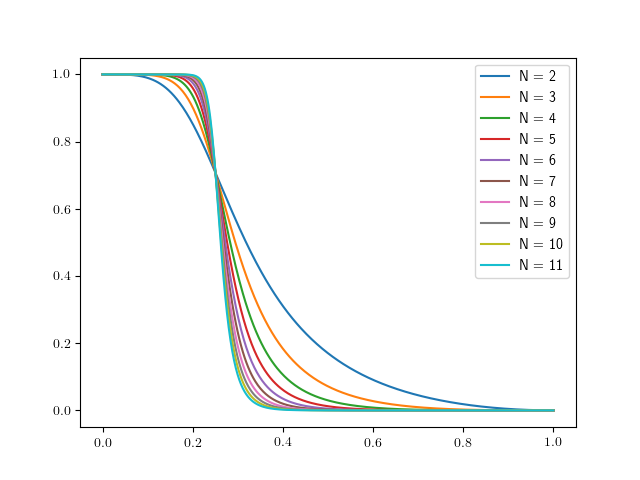

In [11]:
# Let's start by making a low-pass filter with a critical relative frequency of 0.25

fig, ax = plt.subplots(1,1)

for N in range(2,12):
    LP_b, LP_a = signal.butter(N, 0.25, btype='low')      # Create the low-pass filter
    w, h = signal.freqz(LP_b,LP_a)
    amp  = np.sqrt(h.imag**2 + h.real**2)

    ax.plot(w/w.max(), amp, label = 'N = {}'.format(N))
    
ax.legend();

<IPython.core.display.Javascript object>


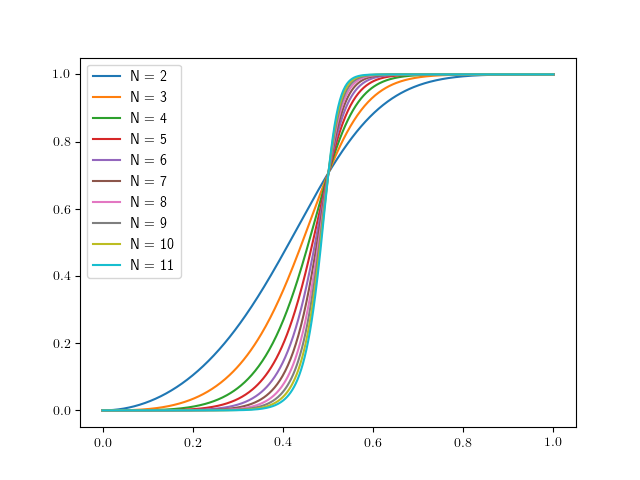

In [13]:
# Now let's make a high-pass filter with a critical relative frequency of 0.50

fig, ax = plt.subplots(1,1)

for N in range(2,12):
    LP_b, LP_a = signal.butter(N, 0.5, btype='high')      # Create the high-pass filter
    w, h = signal.freqz(LP_b,LP_a)
    amp  = np.sqrt(h.imag**2 + h.real**2)

    ax.plot(w/w.max(), amp, label = 'N = {}'.format(N))
    
ax.legend();